In [1]:
import torch
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import cv2
import math
import time
from skimage.feature import peak_local_max

/home/hdc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hdc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hdc/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [2]:
img = cv2.imread('speci2.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
magni,angle = cv2.cartToPolar(sobelx,sobely)

In [3]:
h,w = magni.shape
temp_mean = magni.mean()

In [4]:
def default_weight(*args):
    return 1

def gauss_weight(y,x,center_y,center_x,sigma):
    s = 2*(sigma)**2
    index = -1*((x-center_x)**2+(y-center_y)**2)/s
    weight = math.exp(index)/(s*math.pi)
    return weight

_delta = 30*math.pi/180

def get_area_templates(rmin,rmax,d=_delta,weight=default_weight):
    area_templates = []
    num = 360
    if rmax < 30:
        num = 180
    elif rmax < 15:
        num = 90
    
    radio = 2*math.pi/num
    for i in range(0,num):
        init_area = np.zeros((rmax*2+1,rmax*2+1))
        orient = i*radio
        y = rmax
        x = rmax
        center_y = math.floor(y+((rmin+rmax)/2)*math.sin(orient))
        center_x = math.floor(x+((rmin+rmax)/2)*math.cos(orient))
        for p in range(0,2*rmax+1):
            for q in range(0,2*rmax+1):
                dist = (p-x)**2+(q-y)**2
                if dist > rmin**2 and dist < rmax**2 :
                    vec_angle = math.atan2(q-y,p-x)
                    if vec_angle < 0:
                        vec_angle += math.pi*2
                    angle_diff = abs(vec_angle - orient)
                    if  angle_diff <= d  or angle_diff >= 2*math.pi-d:
                        init_area[q][p] = 1*weight(q,p,center_y,center_x,(rmax-rmin)/2)
                else:
                    continue
        
        area_templates.append(init_area)
    
    return area_templates


def v_a_from_templates(y,x,area_templates,angle):
    orient = (angle[y][x]+math.pi)%(2*math.pi)
    radio =  2*math.pi/len(area_templates)
    index = math.floor((orient/radio)+0.5)
    index = index%len(area_templates) #radius [359.5,360)
    voting_area = np.zeros_like(angle)
    sample = area_templates[index].copy()
    _,lenth = sample.shape
    rmax = (lenth-1)//2
    move_y = rmax-y
    move_x = rmax-x
    
    x_low = max(x-rmax,0)
    x_high = min(x+rmax,w)
    y_low = max(y-rmax,0)
    y_high = min(y+rmax,h)

    s_x_l = x_low + move_x
    s_x_h = x_high + move_x
    s_y_l = y_low + move_y
    s_y_h = y_high + move_y


    voting_area[y_low:y_high,x_low:x_high] = sample[s_y_l:s_y_h,s_x_l:s_x_h]

    return voting_area

In [5]:
area_templates = get_area_templates(5,15,weight=gauss_weight)

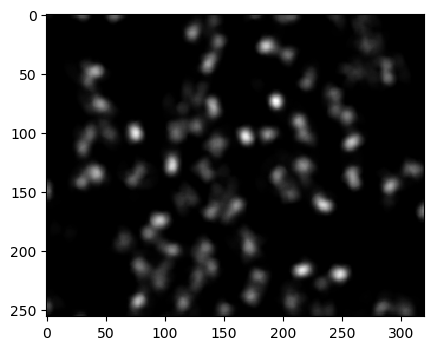

In [6]:
result = []
for i in range(w):
    for j in range(h):
        if magni[j][i] > temp_mean+200:
            result.append(v_a_from_templates(j,i,area_templates,angle))

voting_area = np.zeros_like(magni)
for i in range(len(result)):
    voting_area += result[i]
plt.rcParams['figure.dpi'] = 100
plt.imshow(voting_area,cmap = 'gray')

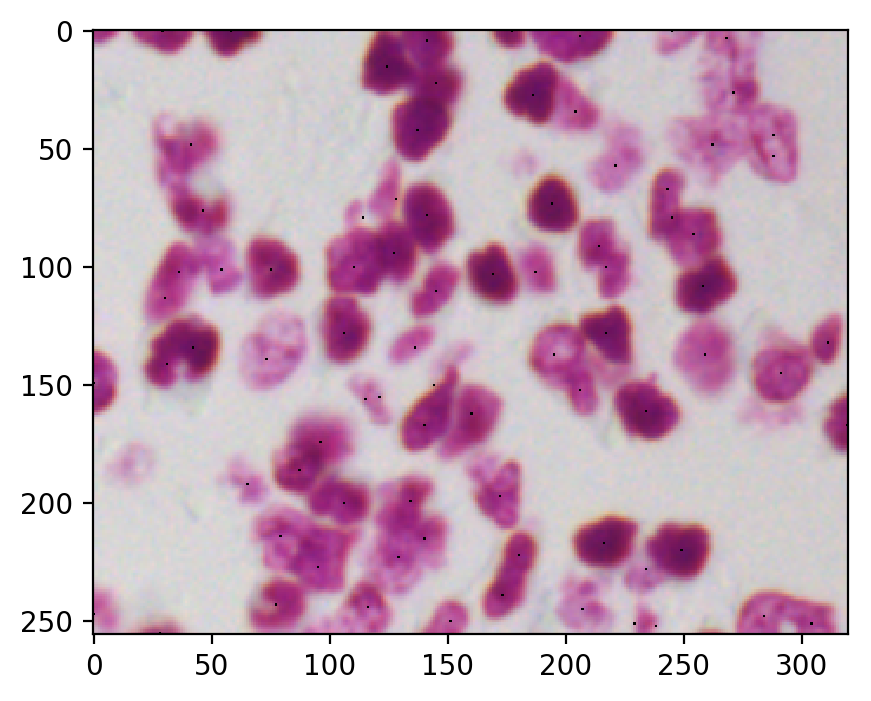

In [7]:
mask = peak_local_max(voting_area,min_distance=4,threshold_rel=0.1,exclude_border=0,indices=False)
show_img = cv2.imread('speci2.png')
show_img[mask] = [0,0,0]
plt.rcParams['figure.dpi'] = 200
plt.imshow(show_img)

In [24]:
thresh,ret = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
im_filled = np.zeros((h+2,w+2),np.uint8)
im_filled[1:h+1,1:w+1] = ret.copy()
mask = np.zeros((h+4,w+4),np.uint8)        
cv2.floodFill(im_filled,mask,(0,0),255)
im_new = im_filled[1:h+1,1:w+1]
ret[im_new==0] = 255

opening = cv2.morphologyEx(ret,cv2.MORPH_ERODE,np.ones((3,3),np.uint8), iterations = 1)

distance_map = cv2.distanceTransform(opening.astype(np.uint8),cv2.DIST_L2,5)


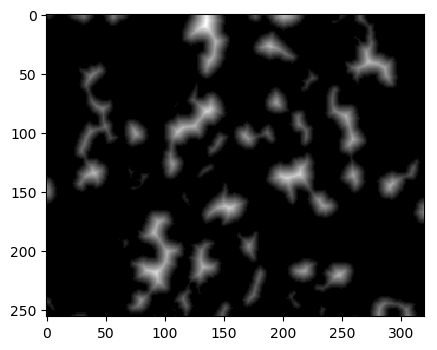

In [25]:
plt.rcParams['figure.dpi'] = 100
plt.imshow(distance_map,cmap='gray')

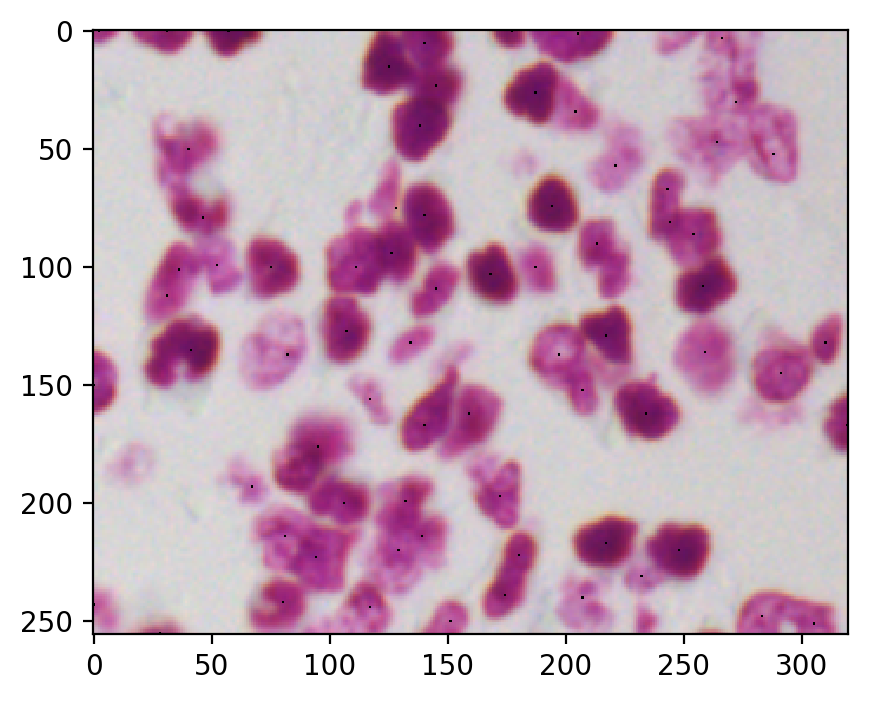

In [31]:
new_area = voting_area*distance_map
cans = peak_local_max(new_area,min_distance=5,threshold_rel=0.04,exclude_border=0,indices=False)
new_img = cv2.imread('speci2.png')
new_img[cans] = [0,0,0]
plt.rcParams['figure.dpi'] = 200
plt.imshow(new_img)

In [ ]:
cv2.